<a href="https://www.kaggle.com/code/nazifkaraca/supervisedlearning?scriptVersionId=197198687" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bitcoin-historical-data/btcusd_1-min_data.csv
/kaggle/input/sp-500-stocks/sp500_stocks.csv
/kaggle/input/sp-500-stocks/sp500_companies.csv
/kaggle/input/sp-500-stocks/sp500_index.csv


# Exploratory Data Analysis (EDA)
 ***Let's start by loading and exploring the dataset.***

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv('/kaggle/input/sp-500-stocks/sp500_stocks.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1861603 entries, 0 to 1861602
Data columns (total 8 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Date       object 
 1   Symbol     object 
 2   Adj Close  float64
 3   Close      float64
 4   High       float64
 5   Low        float64
 6   Open       float64
 7   Volume     float64
dtypes: float64(6), object(2)
memory usage: 113.6+ MB


**Explatory information such as count, mean, std etc.**

In [3]:
df.describe()

,Adj Close,Close,High,Low,Open,Volume
count,1.766724e+06,1.766724e+06,1.766724e+06,1.766724e+06,1.766724e+06,1.766724e+06
mean,9.661940e+01,1.036745e+02,1.048082e+02,1.024839e+02,1.036550e+02,6.967901e+06
std,2.078368e+02,2.080402e+02,2.104503e+02,2.055439e+02,2.079536e+02,3.312065e+07
min,9.377111e-02,2.220000e-01,2.262500e-01,2.162500e-01,2.180000e-01,0.000000e+00
25%,2.892206e+01,3.472000e+01,3.510000e+01,3.432000e+01,3.472000e+01,1.009900e+06
50%,5.392068e+01,6.221000e+01,6.284658e+01,6.153962e+01,6.220000e+01,2.193500e+06
75%,1.034522e+02,1.126100e+02,1.137700e+02,1.113800e+02,1.125900e+02,5.010966e+06
max,9.485570e+03,9.485570e+03,9.555955e+03,9.381800e+03,9.469170e+03,3.692928e+09


**Let's dive into first 5 data points.**

In [4]:
df.head()

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
0,2010-01-04,MMM,44.016735,69.414719,69.774246,69.122070,69.473244,3640265.0
1,2010-01-05,MMM,43.741024,68.979935,69.590302,68.311035,69.230766,3405012.0
2,2010-01-06,MMM,44.361343,69.958191,70.735786,69.824417,70.133781,6301126.0
3,2010-01-07,MMM,44.393150,70.008362,70.033447,68.662209,69.665550,5346240.0
4,2010-01-08,MMM,44.705990,70.501671,70.501671,69.648827,69.974915,4073337.0


# **Data Preprocessing**

***Checking and dealing with any data that may disrupt analyses.***

**Below cell encodes the 'Symbol' column.**

In [5]:
from sklearn.preprocessing import LabelEncoder

# encoding the Symbol column
le = LabelEncoder()
df['Symbol_encoded'] = le.fit_transform(df['Symbol'])

**Because we are developing a prediction model, we are going to do some feature engineering. Let's create new features like daily returns, moving averages and volatility.**

In [6]:
df['Daily_Return'] = df['Adj Close'].pct_change()
df['MA50'] = df['Adj Close'].rolling(window=50).mean()  # 50-day moving average
df['Volatility'] = df['Adj Close'].rolling(window=50).std()  # 50-day volatility

/tmp/ipykernel_17/50090090.py:1: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Daily_Return'] = df['Adj Close'].pct_change()


**Let's define our features. We are going to use Predictors (X) as 'Open', 'High', 'Low', 'Volume', 'Symbol_encoded', 'MA50', 'Volatility', 'Daily_Return' to predict Target (y) 'Adj Close'.**

In [7]:
features = ['Open', 'High', 'Low', 'Volume', 'Symbol_encoded', 'MA50', 'Volatility', 'Daily_Return']
target = 'Adj Close'

**Below cell shows which variables have how many null values and changes them with median value.**

In [8]:
# checked whether there are any missing values
print(df.isnull().sum())

# change missing values only for numeric variable
numeric_columns = df.select_dtypes(include=[np.number]).columns

# fill missing values with the median for each column
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].median())

Date                  0
Symbol                0
Adj Close         94879
Close             94879
High              94879
Low               94879
Open              94879
Volume            94879
Symbol_encoded        0
Daily_Return          1
MA50              98407
Volatility        98407
dtype: int64


**Train-Test Split:** Stock data is time-sensitive, so avoid shuffling the data.

In [9]:
# use 20% of data for testing
split_point = int(len(df) * 0.8)
train_df = df[:split_point]
test_df = df[split_point:]

# train/test split
X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]

# **Supervised Learning Appliance**

***As 'Ebitda' variable continuous (numerical variable), this is a regression problem. Let's implement various models to see how well models perform.***

**Evaluation metrics:**
* **MAE (Mean Absolute Error):** Measures the average magnitude of errors.
* **MSE (Mean Squared Error):** Measures the squared differences between predicted and actual values.

**Visualization of actual prices for better comparison.**

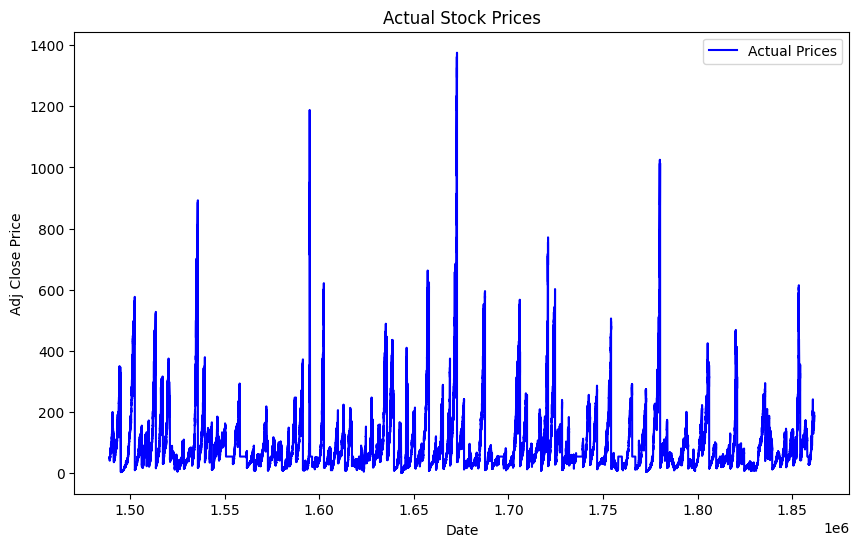

In [10]:
# visualization of actual stock prices
import matplotlib.pyplot as plt

# plot actual stock prices
plt.figure(figsize=(10,6))
plt.plot(test_df.index, y_test, label='Actual Prices', color='blue')
plt.title('Actual Stock Prices')
plt.xlabel('Date')
plt.ylabel('Adj Close Price')
plt.legend()
plt.show()

# XGBoost

**Efficiency and performans is high for regression tasks.**

In [11]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)

# train the model
xgb_model.fit(X_train, y_train)

# make predictions
y_pred = xgb_model.predict(X_test)

# model evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')

Mean Squared Error: 66.6600300180394
Mean Absolute Error: 3.0091617256273695


**Visualization of XGBoost**

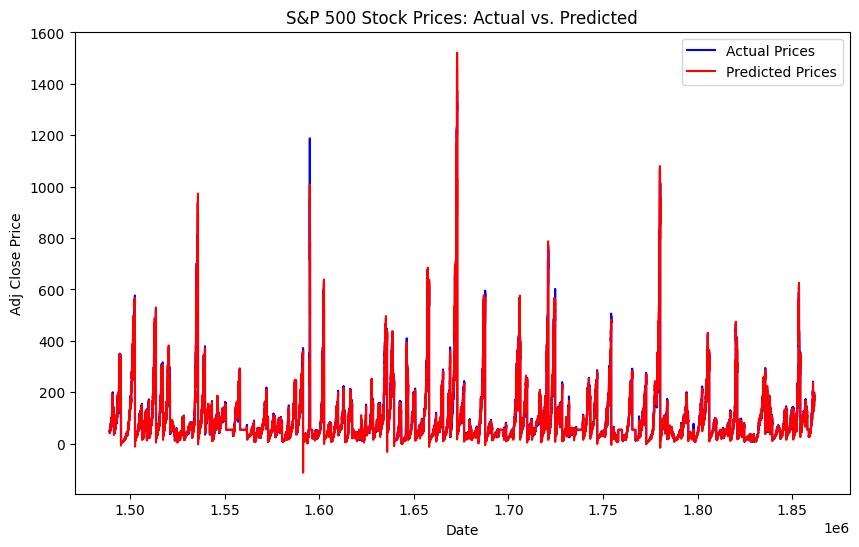

In [12]:
import matplotlib.pyplot as plt

# plot the actual vs predicted prices
plt.figure(figsize=(10,6))
plt.plot(test_df.index, y_test, label='Actual Prices', color='blue')
plt.plot(test_df.index, y_pred, label='Predicted Prices', color='red')
plt.title('S&P 500 Stock Prices: Actual vs. Predicted')
plt.xlabel('Date')
plt.ylabel('Adj Close Price')
plt.legend()
plt.show()

**Evaluation of XGBoost:**
* While the MSE isn't too high, it might indicate that the **model is not capturing extreme price spikes or falls well**.
* **MAE of the model is by about 2.99** units of the adjusted closing price. Given that stock prices in the dataset can vary widely (as seen in the plot), **an average error of ~3 units could be acceptable**, depending on the range of stock prices.
* There seems to be a significant **misalignment** in capturing spikes and dips in prices. The predicted prices (red) consistently overshoot or undershoot during large price swings, which can lead to high error metrics.
* **XGBoost**, while powerful, might be having difficulty capturing sudden and extreme price changes or volatility.

# Random Forest Regressor
**Random Forest is an ensemble of decision trees, which is effective in reducing overfitting.**

In [13]:
# Random Forest Regressor Implementation for Stock Price Prediction
from sklearn.ensemble import RandomForestRegressor

# Initialize the RandomForest Regressor
rf_model = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42)

# Fit the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Calculate evaluation metrics
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)

print(f'Random Forest Mean Squared Error: {mse_rf}')
print(f'Random Forest Mean Absolute Error: {mae_rf}')

Random Forest Mean Squared Error: 15.828649768088557
Random Forest Mean Absolute Error: 2.4555552241783474


**Visualization of Random Forest Regressor**

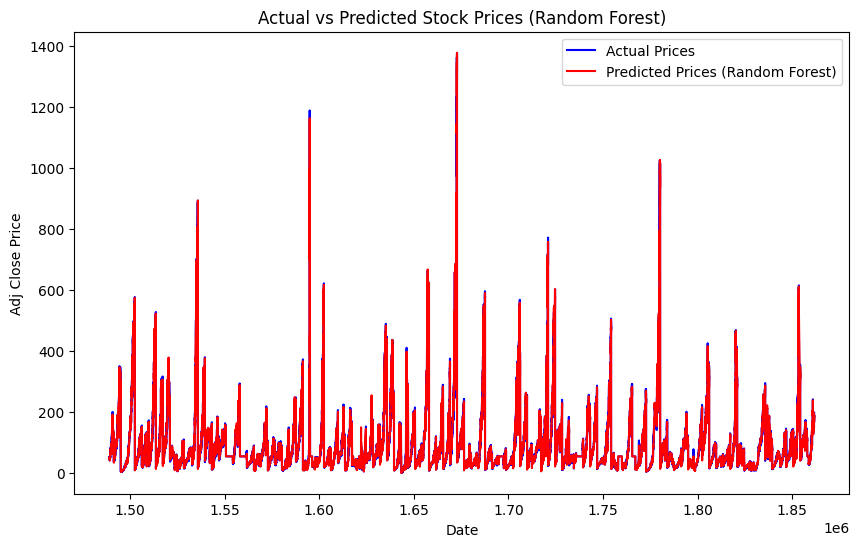

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(test_df.index, y_test, label='Actual Prices', color='blue')
plt.plot(test_df.index, y_pred_rf, label='Predicted Prices (Random Forest)', color='red')
plt.title('Actual vs Predicted Stock Prices (Random Forest)')
plt.xlabel('Date')
plt.ylabel('Adj Close Price')
plt.legend()
plt.show()

**Evaluation of Random Forest Regressor:**
* A lower MSE suggests that the model is now performing better, particularly in handling the overall variability of stock prices.
* The MAE of 2.46 means that, on average, the model's predictions are off by about 2.46 units from the actual Adj Close price. **This is a reasonable MAE**, especially given the complexity and variability of stock price data.
* The plot shows that the predicted prices (red line) follow the actual prices (blue line) closely in most areas, but there are still discrepancies during the spikes. The model is **struggling to capture the extreme price spikes, which is common in stock price predictions**, especially when prices fluctuate drastically.

# Support Vector Regression
**SVR is robust in capturing non-linear patterns, especially with the RBF kernel, and it often performs well on datasets with noise.**

SVR requires the data to be scaled since it is sensitive to the magnitude of the features.

In [15]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Define and fit scalers for X (features) and y (target)
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Fit the scaler on the full training data first
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))

In [16]:
# Use 10% of the data for training SVR (sampling)
X_train_sample = X_train.sample(frac=0.1, random_state=42)
y_train_sample = y_train.sample(frac=0.1, random_state=42)

X_train_scaled_sample = scaler_X.transform(X_train_sample)
y_train_scaled_sample = scaler_y.transform(y_train_sample.values.reshape(-1, 1))

# Train the SVR model on the sample
svr_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
svr_model.fit(X_train_scaled_sample, y_train_scaled_sample.ravel())

SVR(C=100, gamma=0.1)

Let's train SVR model.

In [17]:
# Cell 3: Scale the test data (this was missing, causing the error)
X_test_scaled = scaler_X.transform(X_test)  # Scale the test features

# Make predictions on the scaled test data
y_pred_scaled = svr_model.predict(X_test_scaled)

# Inverse transform the predictions back to the original scale
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))

# Calculate evaluation metrics (MSE, MAE)
mse_svr = mean_squared_error(y_test, y_pred)
mae_svr = mean_absolute_error(y_test, y_pred)

print(f'SVR Mean Squared Error: {mse_svr}')
print(f'SVR Mean Absolute Error: {mae_svr}')

SVR Mean Squared Error: 686.3033253381656
SVR Mean Absolute Error: 12.180049717468059


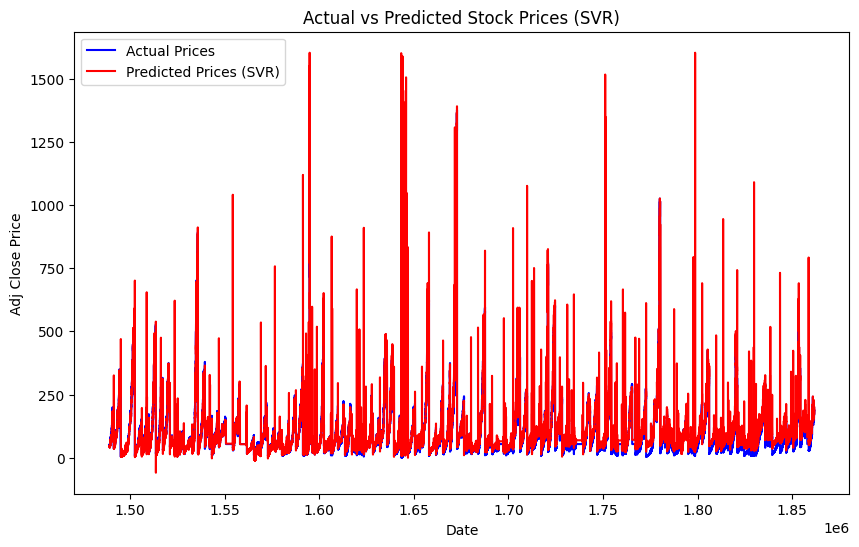

In [18]:
plt.figure(figsize=(10,6))
plt.plot(test_df.index, y_test, label='Actual Prices', color='blue')
plt.plot(test_df.index, y_pred, label='Predicted Prices (SVR)', color='red')
plt.title('Actual vs Predicted Stock Prices (SVR)')
plt.xlabel('Date')
plt.ylabel('Adj Close Price')
plt.legend()
plt.show()